
 <font size="5"> SHAP - Shapley Additive exPlanations</font>  
 <font size="3"> *If we have a coalition C that collaborates to produce a value V: How much did each individual member contributed to the final value?*</font>  


#there is always some base rate. Ability to debug and understand the algorithm. Why the model has done the decision it has done. We need to explain how we got from base rate (not knowing anything) to the outcome rate (after all features are used). Going through the features one entry at a time. Compare to the mean value. The outcome of the shaply is the mean centered partial dependence plot.
#The order how we introduce the features one by one matter (need to count in the interaction effects). We can't go through all combinations, because it is NP-hard problem. Shap package allows us to calculate these values efficiently and effectivelly. 

Shaply value is the average amount of contribution that a particular member makes to the coalition value.

In [145]:
import sklearn.datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap


In [146]:
# Source: https://data.world/health/breast-cancer-wisconsin
breast_cancer_wisconsin_df = pd.read_csv('https://query.data.world/s/x5i2pqqfvpfs47ys5fynpljbs2itqr')

In [147]:
breast_cancer_wisconsin_df.drop(['id', 'Unnamed: 32'], axis='columns',inplace=True)
# Diagnosis (M = malignant (1), B = benign (0))
breast_cancer_wisconsin_df['diagnosis'] = np.where(breast_cancer_wisconsin_df['diagnosis'] == 'M', 1, 0)
breast_cancer_wisconsin_df


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [148]:
# features list
features = [feature for feature in list(breast_cancer_wisconsin_df) if feature != 'diagnosis']
x_train, x_test, y_train, y_test = train_test_split(breast_cancer_wisconsin_df[features],breast_cancer_wisconsin_df[['diagnosis']], test_size=0.3)
model = RandomForestClassifier(n_estimators=150, n_jobs=2)
model.fit(x_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(n_estimators=150, n_jobs=2)

In [149]:
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.32%


In [150]:
x_test['Prediction'] = model.predict_proba(x_test)[:, 1]

In [151]:
#model.predict_proba(x_test[features])[:, 1]

In [152]:
#breast_cancer_wisconsin_df[['diagnosis']].describe()

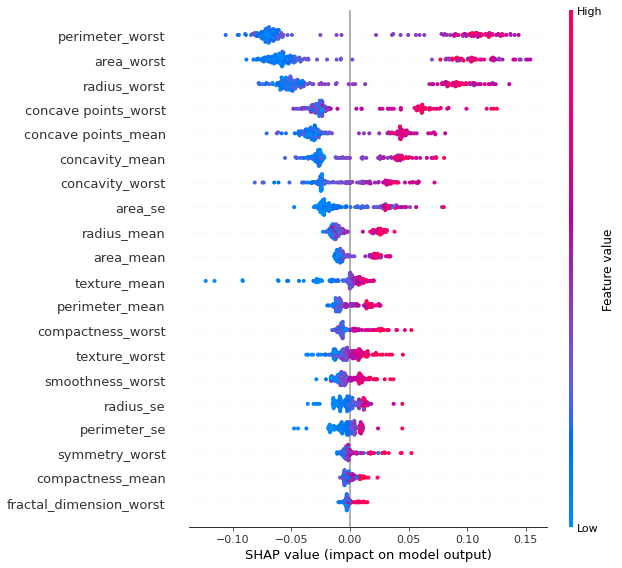

In [174]:
# Calculating shap values
explainer = shap.TreeExplainer(model)
#Xd = xgb.DMatrix(breast_cancer_wisconsin_df[features],breast_cancer_wisconsin_df[['diagnosis']])
#Xd = xgb.DMatrix(x_test[features],y_test)
#shap_values = explainer.shap_values(Xd)
shap_values = explainer.shap_values(x_test[features])
shap.summary_plot(shap_values[1], x_test[features])

In [154]:
#breast_cancer_wisconsin_df[['area_worst']].describe() #the most important feature

In [155]:
shap_values_df = pd.DataFrame(shap_values[1], columns = features)
#shap_values_df = shap_values_df.join(y_test.reset_index())
# move diagnosis column to front
#diagnosis = shap_values_df.pop('diagnosis')
#shap_values_df.insert(0, 'diagnosis', diagnosis)


In [156]:
###shap values of each case
shap_values_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.029129,-0.043369,0.016049,0.020608,-0.000687,0.003489,0.050050,0.049017,0.000122,0.000435,...,0.093079,-0.006614,0.120074,0.106770,-0.008881,-0.002847,0.032802,0.068424,-0.001188,-0.001261
1,-0.016590,0.001887,-0.013415,-0.011064,0.001865,-0.005141,-0.029147,-0.038031,-0.001075,0.000333,...,-0.057908,0.007270,-0.071989,-0.065088,0.010173,-0.010450,-0.027298,-0.029462,-0.003216,-0.002444
2,-0.009672,0.000143,-0.007752,-0.008047,0.000546,-0.004210,-0.028918,-0.031264,-0.000939,-0.000386,...,-0.049069,-0.006693,-0.067264,-0.056590,-0.000610,-0.006921,-0.025843,-0.027825,-0.003572,-0.003309
3,-0.002638,0.012026,0.001640,0.001922,-0.001251,0.004895,0.039617,0.056960,0.002099,0.002032,...,0.067694,0.031098,0.080066,-0.007617,0.022452,0.033175,0.046940,0.116625,0.033099,0.004871
4,0.023605,0.005970,0.015400,0.022004,-0.001747,0.008031,0.042015,0.047452,-0.001368,0.001034,...,0.083987,0.004359,0.107186,0.096939,-0.005350,0.024573,0.034061,0.057049,-0.001319,-0.001240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,0.024422,0.007310,0.017653,0.022741,-0.001510,0.009160,0.037870,0.040599,0.001024,0.000909,...,0.080263,0.008537,0.102318,0.087539,-0.006325,0.028098,0.031294,0.059799,0.018349,0.001634
167,0.031176,0.007139,0.019390,0.026181,-0.001988,0.001589,0.028886,0.042687,-0.001521,-0.000190,...,0.104257,0.004725,0.118414,0.120198,-0.005518,-0.006804,0.006129,0.057240,-0.003096,-0.002140
168,-0.015292,0.013611,-0.012316,-0.011385,0.001220,-0.003902,-0.027655,-0.032461,-0.000947,0.000209,...,-0.056541,0.026072,-0.074160,-0.064622,0.020874,-0.007404,-0.026817,-0.026605,0.004715,-0.001899
169,-0.011925,-0.000188,-0.011073,-0.008551,0.001613,-0.004362,-0.032115,-0.037459,-0.000560,-0.000350,...,-0.042346,-0.000349,-0.064188,-0.050821,-0.005165,-0.010075,-0.032670,-0.034128,-0.003480,-0.003782


In [157]:
x_test

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Prediction
372,21.37,15.10,141.30,1386.0,0.10010,0.15150,0.19320,0.12550,0.1973,0.06183,...,21.84,152.10,1535.0,0.1192,0.2840,0.4024,0.19660,0.2730,0.08666,0.940000
80,11.45,20.97,73.81,401.5,0.11020,0.09362,0.04591,0.02233,0.1842,0.07005,...,32.16,84.53,525.1,0.1557,0.1676,0.1755,0.06127,0.2762,0.08851,0.006667
325,12.67,17.30,81.25,489.9,0.10280,0.07664,0.03193,0.02107,0.1707,0.05984,...,21.10,88.70,574.4,0.1384,0.1212,0.1020,0.05602,0.2688,0.06888,0.000000
214,14.19,23.81,92.87,610.7,0.09463,0.13060,0.11150,0.06462,0.2235,0.06433,...,34.85,115.00,811.3,0.1559,0.4059,0.3744,0.17720,0.4724,0.10260,0.933333
272,21.75,20.99,147.30,1491.0,0.09401,0.19610,0.21950,0.10880,0.1721,0.06194,...,28.18,195.90,2384.0,0.1272,0.4725,0.5807,0.18410,0.2833,0.08858,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,19.07,24.81,128.30,1104.0,0.09081,0.21900,0.21070,0.09961,0.2310,0.06343,...,33.17,177.40,1651.0,0.1247,0.7444,0.7242,0.24930,0.4670,0.10380,0.986667
70,18.94,21.31,123.60,1130.0,0.09009,0.10290,0.10800,0.07951,0.1582,0.05461,...,26.58,165.90,1866.0,0.1193,0.2336,0.2687,0.17890,0.2551,0.06589,0.993333
248,10.65,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,0.06329,...,35.19,77.98,455.7,0.1499,0.1398,0.1125,0.06136,0.3409,0.08147,0.046667
93,13.45,18.30,86.60,555.1,0.10220,0.08165,0.03974,0.02780,0.1638,0.05710,...,25.94,97.59,699.4,0.1339,0.1751,0.1381,0.07911,0.2678,0.06603,0.013333


Shap value interpretability
1. Sum of SHAP values for one value (0.54)
2. Average prediction of all values (0.03)
3. Actual prediction of one value (0.57)

In [158]:
shap_values[1][3].sum()

0.5518090452261306

In [159]:
x_test['Prediction'].mean()

0.3374658869395712

In [160]:
x_test['Prediction'].iloc[3]-x_test['Prediction'].mean()

0.5958674463937621

In [161]:
# some tests to evaluate if shap values are calculated correctly
test_value = 5

sum_shap = shap_values[1][test_value].sum() #sum of shap values for the first case in the dataframe
mean_of_all_predictions = x_test['Prediction'].mean()
current_prediction = x_test['Prediction'].iloc[test_value]
print(f'Sum of all shap values for the selected row are {sum_shap}, that should be equal to base rate (mean of all prediction) {mean_of_all_predictions} minus the current selected row prediction {current_prediction}. ')
#explainer.expected_value


Sum of all shap values for the selected row are -0.3281909547738694, that should be equal to base rate (mean of all prediction) 0.3374658869395712 minus the current selected row prediction 0.05333333333333334. 


In [169]:
expected_value = explainer.expected_value
#shap_values2 = shap_values[:,:-1]
shap.initjs()
shap.force_plot(expected_value[1], shap_values[1])


In [173]:
shap.initjs()
shap.force_plot(expected_value[1], shap_values[1][11], x_test[features].iloc[11])